Step #100 A = [[ 0.6380832 ]
 [-0.35183528]] b = [[1.0143793]]
Loss = [0.9576475]
Step #200 A = [[ 0.48613635]
 [-0.32331318]] b = [[0.97167933]]
Loss = [0.9914495]
Step #300 A = [[ 0.33293808]
 [-0.30569685]] b = [[0.9556796]]
Loss = [0.8674367]
Step #400 A = [[ 0.22826697]
 [-0.28117943]] b = [[0.9342793]]
Loss = [0.91490114]
Step #500 A = [[ 0.18585844]
 [-0.24494992]] b = [[0.9165796]]
Loss = [0.8446613]


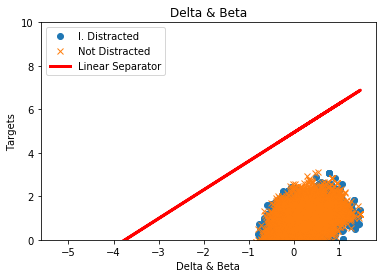

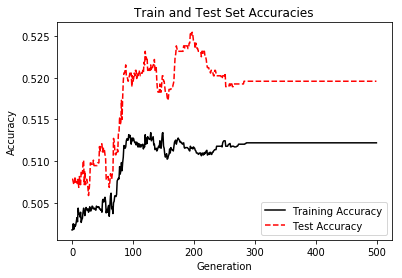

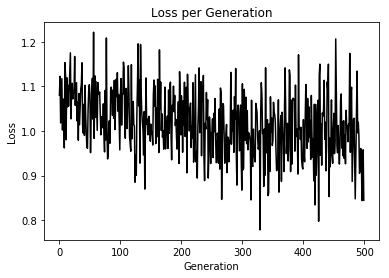

In [93]:
"""
Experimenting with support vector machines
"""
# Importing all the libraries 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Reading from the csv file.
path = r'/Users/KaushikBhimraj/Desktop/Merged_Data.csv'

# List comprehension used to create numpy arrays for inputs and targets.
BetaDelta   = np.array([[line.split(',')[0], line.split(',')[1]] for line in open(path) if line[0:1] != '\n'])
Target      = np.array([line.split(',')[2] for line in open(path) if line[0:1] != '\n'])

# Removing the heading row and converting the string values to int.
BetaDelta   = BetaDelta[1:]
BetaDelta   = BetaDelta.astype(np.float)

# Converting Target to -1 or 1 format.
Target      = np.array([1 if y == "Distracted\n" else -1 for y in Target])

# Spliting the datasets into training and testing portions
sess          = tf.Session()
train_indices = np.random.choice(len(BetaDelta), round(len(BetaDelta) * 0.8), replace=False)
test_indices  = np.array(list(set(range(len(BetaDelta))) - set(train_indices)))

Beta_train    = BetaDelta[train_indices]
Beta_test     = BetaDelta[test_indices]
Target_train  = Target[train_indices]
Target_test   = Target[test_indices]

# Here we want a very large batch size to achieve convergence. 
# The A variable will take on the 2 x 1 shape. (In the book, this is done because there are 2 predictor variables.)
batch_size    = 100
x_data        = tf.placeholder(shape = [None, 2], dtype=tf.float32)
y_target      = tf.placeholder(shape = [None, 1], dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[2,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# For correctly classified points, values of >= 1 if target is 1.
model_output = tf.subtract(tf.matmul(x_data, A), b)

# Calculate the L2 normm of a vector. 
# Margin parameter: a
l2_norm      = tf.reduce_sum(tf.square(A))
alpha        = tf.constant([0.1])

# Declaring classification loss and adding together the two terms.
classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(model_output, y_target))))
loss                = tf.add(classification_term, tf.multiply(alpha, l2_norm))

# Declaring the prediction and accuracy functions to evaluate bot the training and test sets.
prediction = tf.sign(model_output)
accuracy   = tf.reduce_mean(tf.cast(tf.equal(prediction, y_target), tf.float32))

# Declaring optimization function and initializing model variables.
my_opt     = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)
init       = tf.global_variables_initializer()
sess.run(init)

# Starting the training loop. 
# Making sure to record loss and training accuracy for both training and test sets. 
loss_vec = []
train_accuracy = []
test_accuracy  = []

for i in range(500):
    rand_index = np.random.choice(len(Beta_train), size=batch_size)
    rand_x     = Beta_train[rand_index]
    rand_y     = np.transpose([Target_train[rand_index]])
    no_end     = sess.run(train_step, feed_dict = {x_data: rand_x, y_target: rand_y})
    
    # Storing the loss from each iteration into loss_vec
    temp_loss  = sess.run(loss, feed_dict = {x_data:rand_x, y_target:rand_y})
    loss_vec.append(temp_loss)
    
    #
    train_acc_temp = sess.run(accuracy, feed_dict={x_data:Beta_train, y_target:np.transpose([Target_train])})
    train_accuracy.append(train_acc_temp)
    
    #
    test_acc_temp = sess.run(accuracy, feed_dict={x_data:Beta_test, y_target:np.transpose([Target_test])})
    test_accuracy.append(test_acc_temp)
    
    if (i+1)%100 == 0:
        print('Step #' + str(i + 1) + ' A = ' + str(sess.run(A)) + ' b = ' + str(sess.run(b)))
        print('Loss = ' + str(temp_loss))
        

# Plotting the outputs (fit, loss and accuracy), the coefficients.
[[a1], [a2]] = sess.run(A)
[[b]]        = sess.run(b)
slope        = -a2/a1
y_intercept  = b/a1
x1_vals       = [d[1] for d in BetaDelta]

best_fit     = []
for i in x1_vals:
    best_fit.append(slope*i+y_intercept)

setosa_x = [d[1] for i,d in enumerate(BetaDelta) if Target[i] == 1]
setosa_y = [d[0] for i,d in enumerate(BetaDelta) if Target[i] == 1]
not_setosa_x = [d[1] for i,d in enumerate(BetaDelta) if Target[i] == -1]
not_setosa_y = [d[0] for i,d in enumerate(BetaDelta) if Target[i] == -1]

plt.plot(setosa_x, setosa_y, 'o', label='I. Distracted')
plt.plot(not_setosa_x, not_setosa_y, 'x', label='Not Distracted')
plt.plot(x1_vals, best_fit, 'r-', label='Linear Separator', linewidth=3)
plt.ylim([0, 10])
plt.legend(loc='upper left')
plt.title('Delta & Beta')
plt.xlabel('Delta & Beta')
plt.ylabel('Targets')
plt.show()

plt.plot(train_accuracy, 'k-', label='Training Accuracy')
plt.plot(test_accuracy, 'r--', label='Test Accuracy')
plt.title('Train and Test Set Accuracies')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()